# Everything to Know About Flight Delays

This is the technical version of an article that analyzes post-Covid flight information up to August 2022 (the latest available as of today). Of great interest are flight delays.

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import zipfile
import os
import requests
from pathlib import Path
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

## Downloading the data

To investigate flights in the United States, there is no greater resource than the US Department of Transportation's [Bureau of Transportation Statistics](https://www.transtats.bts.gov/DL_SelectFields.aspx?gnoyr_VQ=FGJ&QO_fu146_anzr=b0-gvzr). They have a handy HTML page that we can download the data from. The data is available by month, meaning that we must obtain data for each month of all years we are interested in.

We can automate this download with the requests library of Python, setting START_YEAR to the beginning year of the period of interest and END_YEAR to the end year (exclusive).

In [2]:
START_YEAR = 2022
END_YEAR = 2024

In [3]:
os.mkdir("data")

In [ ]:
for i in range(START_YEAR, END_YEAR):
    for j in range(1,13):
        #We set verify to False because an SSL cert error gets thrown otherwise for some reason
        r = requests.get(f"https://transtats.bts.gov/PREZIP/On_Time_Reporting_Carrier_On_Time_Performance_1987_present_{i}_{j}.zip", verify=False)
        with open(f"data/On_Time_Reporting_Carrier_On_Time_Performance_1987_present_{i}_{j}.zip", "wb") as fd:
            fd.write(r.content)

At this point, we have a bunch of `zip` files, one for each month of flights. We'll unzip them one-by-one.

In [ ]:
#Construct an array to hold our zip filepaths
zips = []
for root, directories, filenames in os.walk('data'):
    for directory in directories:
         dpath = os.path.join(root, directory)

    for filename in filenames:
        fpath = os.path.join(root,filename)
        if fpath[-3:] == 'zip':
            zips.append(fpath)

for zip_path in zips:
    try:
        my_zip = zipfile.ZipFile(zip_path, 'r')
        my_zip.extractall('data')
    except zipfile.BadZipFile:
        continue

## Reading in and cleaning data

Now, we read the data in and clean it. We start out by reading in an arbitrary month to get a DataFrame with the correct columns, then loop through each month's flight records (stored in a `csv`). We add each month's flight records to our `flights` DataFrame; at this point, we are done loading data for this project.

Cleaning the DataFrames involves several steps. To start, we read in [this](https://www.bts.gov/topics/airlines-and-airports/airline-codes) HTML table from the Bureau of Transportation Statistics as a DataFrame. This table matches airlines with abbreviations. To aid legibility, we replace the abbreviations contained in our `flights` DataFrame with the airlines' full names.

In [ ]:
import re

#Obtains DataFrame with correct columns
flights = pd.DataFrame(columns=pd.read_csv("data/On_Time_Reporting_Carrier_On_Time_Performance_(1987_present)_2022_5.csv").columns)

#Concatenates inputs to flights DataFrame
for root, directories, filenames in os.walk('data'):
    for filename in filenames:
        fpath = os.path.join(root,filename)
        if (fpath[-3:] == 'csv') & (fpath[5:8] == 'On_'):
            a = pd.read_csv(fpath)

            # Filter out unneeded rows (only keep things relevant to flight origin, airline, and departure delay)
            a = a.filter(['CRSDepTime', 'DepDelayMinutes', 'Reporting_Airline', 'TaxiOut', 'Origin', 'Flight_Number_Reporting_Airline'], axis=1)

            # Concatenate month table to flights
            print(f"  {fpath}")
            flights = pd.concat([flights, a], ignore_index=True, join='inner')

# Obtains a DataFrame version of the HTML table on the BTS Airline Codes webpage
codes = pd.read_html("https://www.bts.gov/topics/airlines-and-airports/airline-codes")[0]
flights = flights.merge(right=codes, left_on='Reporting_Airline', right_on='Code', suffixes=['',''])#.drop(["Reporting_Airline", 'Code'], axis=1)

We now make a copy of `flights` called `delays`. We can now safely transform our data and keep the original flights available for later analysis. We'll also regularize our time (converting the HHMM format to HH.MM, where MM is out of 100 instead of 60).

In [7]:
# Makes a deep copy of flights called delays for transformation in this section. Filter out on-time flights.
flights['CRSDepTime'] = flights['CRSDepTime'] % 100 * 5/3 * .01 + flights['CRSDepTime'] // 100
flights['delay'] = flights['DepDelayMinutes'] > 0
delays = flights.copy(deep=True)[flights['DepDelayMinutes'] > 0]

## Plot of flight delays vs departure time

Let's take a precursory view of flight delays in the aggregate and see how they correlate with departure time.

([<matplotlib.axis.XTick at 0x7fc51928ddb0>,
 [Text(0, 0, '12am'),
  Text(4, 0, '4am'),
  Text(8, 0, '8am'),
  Text(12, 0, '12pm'),
  Text(16, 0, '4pm'),
  Text(20, 0, '8pm')])

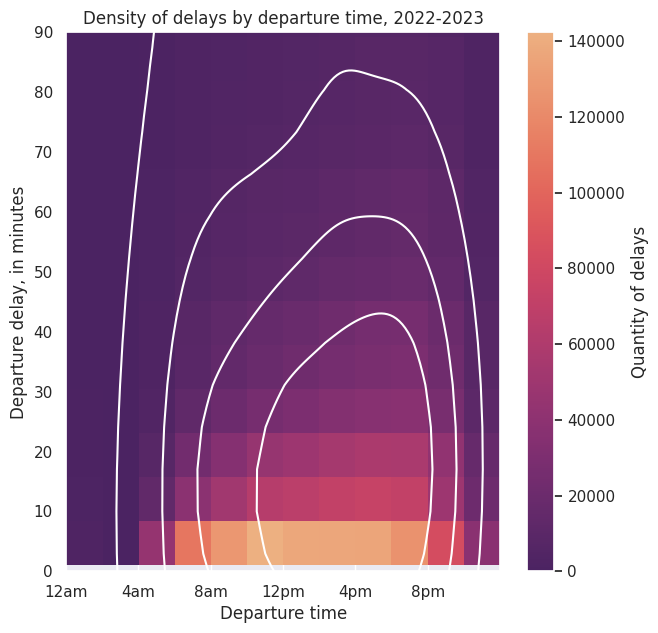

In [8]:
sns.set_theme()

f, ax = plt.subplots(figsize=(7, 7), sharex=True, sharey=True)
a = sns.histplot(data=delays, x='CRSDepTime', y='DepDelayMinutes', bins=[12,600],
                 cmap=sns.color_palette("flare_r", as_cmap=True), cbar=True, cbar_kws={'label': 'Quantity of delays'})
sns.kdeplot(data=delays.sample(1000), x='CRSDepTime', y='DepDelayMinutes', levels=5, color="w")

plt.title('Density of delays by departure time, ' + str(START_YEAR) + "-" + str(END_YEAR - 1))
plt.xlabel('Departure time')
plt.ylabel('Departure delay, in minutes')
plt.xlim((0, 24))
plt.ylim(bottom=0, top=90)
plt.xticks(range(0,24,4), ['12am','4am','8am','12pm','4pm','8pm'])

We see that delays are densest between 10am and 8pm. The most common delay takes less than 10 minutes. Next, we'll look at significant delays, which I will define to be greater than or equal to 30 minutes in length.

## Plot of  delays greater than 30 minutes vs departure time

We filter all delays <= 30 minutes out of the `delays` table.

In [9]:
def delay_significance(x):
    """Categorizes delays into one of three categories."""
    if x == 0:
        return "On Time"
    elif x < 30 and x > 0:
        return "Slight Delay"
    else:
        return "Significant Delay"

#Creates labels for hue sorting on histogram.
flights['Delay Status'] = flights['DepDelayMinutes'].apply(delay_significance)

Below, you can see all significant flight delays plotted against on-time flights.


([<matplotlib.axis.XTick at 0x7fc52b1e4b20>,
 [Text(0, 0, '12am'),
  Text(4, 0, '4am'),
  Text(8, 0, '8am'),
  Text(12, 0, '12pm'),
  Text(16, 0, '4pm'),
  Text(20, 0, '8pm')])

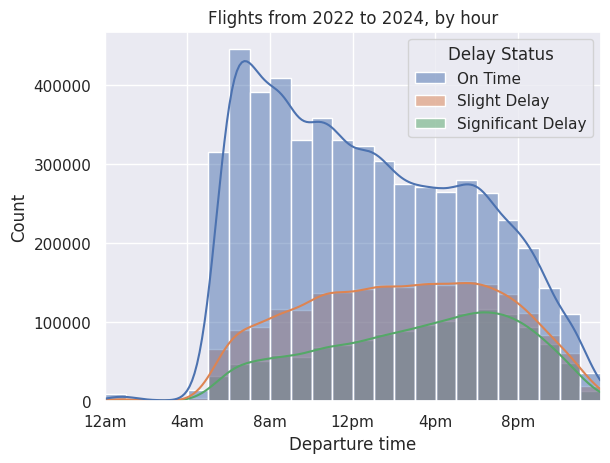

In [10]:
sns.histplot(flights, x='CRSDepTime', kde=True, hue='Delay Status',
             binwidth=1, kde_kws={'bw_adjust': 3}).set(xlabel='Departure time', title='Flights from '
                             + str(START_YEAR) + ' to ' + str(END_YEAR) + ', by hour')

plt.xlim(0,24)
plt.xticks(range(0,24,4), ['12am','4am','8am','12pm','4pm','8pm'])

From the chart, we see that both slight and significant delays increase as the day goes on, although significant delays have a more consistent increase between 6am and 6pm, while slight delays seem to plateau around 10am.

## Delays by airline

Now, let's look at delays by airline. We merge wholly-owned subsidiaries with their parent company (a complete list of wholly-owned subsidiary airlines in North America can be found on [Wikipedia](https://en.wikipedia.org/wiki/Regional_airline)), as people do not often see their brand nor purchase from them. Some airlines, such as Republic Airline, are regional airlines that fly under multiple airline names; our data does not represent whose banner they fly under for a given flight, making it impossible for us to merge their flights with their contracted carrier.

In [11]:
# Adds new departure hour columns to flights and delays for easier charting
flights['CRSDepHour'], delays['CRSDepHour'] = flights['CRSDepTime'] // 1,  delays['CRSDepTime'] // 1

#Selects only for significant delays
delays = delays[delays['DepDelayMinutes'] >= 30]

# Merges wholly-owned subsidiary airlines with their parent companies
delays_ma = delays.replace(to_replace={"Airline": {"Horizon Air":"Alaska Airlines Inc.", "Envoy Air":"American Airlines Inc.", "PSA Airlines Inc.":"American Airlines Inc.", "Endeavor Air Inc.": "Delta Air Lines Inc."}})
flights_ma = flights.replace(to_replace={"Airline": {"Horizon Air":"Alaska Airlines Inc.", "Envoy Air":"American Airlines Inc.", "PSA Airlines Inc.":"American Airlines Inc.", "Endeavor Air Inc.": "Delta Air Lines Inc."}})

def airline_delay_frequencies(airline, delays, flights):
    """Returns delay proportions, grouped by departure hour and departure time."""
    total_delays = delays[delays['Airline'] == airline].groupby('CRSDepHour')['CRSDepTime'].count()
    total_flights = flights[flights['Airline'] == airline].groupby('CRSDepHour')['CRSDepTime'].count()
    return (total_delays / total_flights).reindex(np.arange(24), fill_value=0) * 100

# Accumulates multiple airline Series into a DataFrame for line plot
airlines = ['American Airlines Inc.', #'SkyWest Airlines Inc.',
       'Alaska Airlines Inc.', 'United Air Lines Inc.',
       'Delta Air Lines Inc.', 'Frontier Airlines Inc.', #'Allegiant Air',
       #'Hawaiian Airlines Inc.',
        'Spirit Air Lines',
       'Southwest Airlines Co.', #'Mesa Airlines Inc.', 'Republic Airline',
       'JetBlue Airways']
proportions = pd.DataFrame()
for airline in airlines:
    proportions[airline] = airline_delay_frequencies(airline, delays_ma, flights_ma)

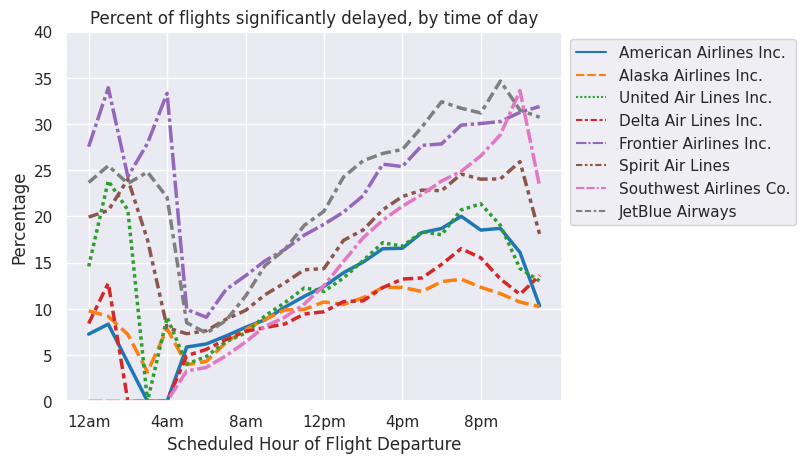

In [12]:
# Constructs a bar plot of flight delay percentage according to time
a = sns.lineplot(data=proportions, palette="tab10", linewidth=2.5)
plt.xlabel("Scheduled Hour of Flight Departure")
plt.ylabel("Percentage")
plt.title("Percent of flights significantly delayed, by time of day")
plt.xticks(range(0,24,4), ['12am','4am','8am','12pm','4pm','8pm'])
plt.ylim(0, 40)
sns.move_legend(a, "upper left", bbox_to_anchor=(1, 1))

As a proportion of total flights, the chance of significant delay is lowest in the early hours of the morning, regardless of airline. From there, the chance of delay steadily increases and peaks in the evening. Then there is a dip around midnight, with delays skyrocketing in the wee hours of the morning.

The budget airlines (Frontier, Spirit, Southwest, and JetBlue) all have higher rates of delay throughout the day according to this dataset, with the exception of Southwest, which has a delay rate comparable with the non-budget airlines in the morning. However, by 12pm, Southwest's significant delay rate grows past that of the non-budget airlines and joins its budget peers by 4 or 5 pm.



After aggregating budget and non-budget airlines, we can notice a large difference between budget airline performance and non-budget performance in terms of significant delays.

By the numbers:

In [13]:
(delays.groupby('Airline').count()[['CRSDepTime']] / flights.groupby('Airline').count()[['CRSDepTime']] * 100).sort_values('CRSDepTime', ascending=False).rename({'CRSDepTime':'% Flights Significantly Delayed'}, axis=1)

,% Flights Significantly Delayed
Airline,
JetBlue Airways,22.078514
Frontier Airlines Inc.,21.896298
Allegiant Air,18.991785
Spirit Air Lines,16.958591
Southwest Airlines Co.,15.292280
American Airlines Inc.,14.529106
Mesa Airlines Inc.,13.838768
United Air Lines Inc.,12.994220
Hawaiian Airlines Inc.,11.101448


# Applications: LAX vs BUR, SFO vs OAK

I want to talk about why I felt inspired to examine flights in the first place. As a college student, I often take Southwest to-and-from school due to its cheap fares and customer service.

Southern California common wisdom dictates that one should fly out of Burbank Airport whenever possible to avoid LAX delays. Coming to the Bay Area for college, I expected Oakland and San Francisco to share a similar large/small airport dynamic. However, I was surprised to hear that some of my friends preferred SFO over OAK. In this section, we will determine whether SFO>OAK and BUR>LAX.

I follow a similar approach as before but select only flight records that contain our desired origin airports.

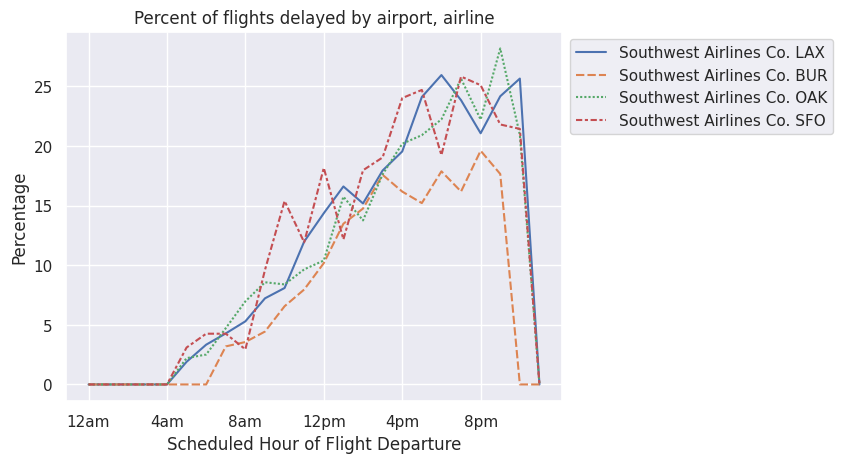

In [14]:
def compare_airports(airlines, airports, delays, flights):
    """ Returns a DataFrame with delay rates by airport and airline. Indices follow the format 'airline airport.'
    airlines' and airports must be lists. delays and flights are DataFrames as created above.
    """
    proportions = pd.DataFrame()
    for airline in airlines:
        for origin in airports:
            proportions[airline + " " + origin] = airline_delay_frequencies(airline,
                            delays[delays['Origin'] == origin], flights[flights['Origin'] == origin])
    return proportions

# Construct a bar plot of flight delay percentage according to time
a = sns.lineplot(data=compare_airports(['Southwest Airlines Co.'], ['LAX', 'BUR', 'OAK', 'SFO'], delays_ma, flights_ma))
plt.xlabel("Scheduled Hour of Flight Departure")
plt.ylabel("Percentage")
plt.title("Percent of flights delayed by airport, airline")
plt.xticks(range(0,24,4), ['12am','4am','8am','12pm','4pm','8pm'])
sns.move_legend(a, "upper left", bbox_to_anchor=(1, 1))

In fact, BUR has fewer delays than LAX, OAK, and SFO. Burbank is better than LAX, but Oakland and SFO are about the same.